## Growth Rate Analysis

The purpose of this notebook is to:

- Read cell data from preprocessed HDF5 DB
- Filter cells where appropriate
- Infer growth rates within apartments
- Plot results

### Parameters

In [2]:
# # Debugging
data_dir = '/lab/data/celldom/output/experiment_01'
start_of_experiment = '2018-05-31 16:10:00'
min_cell_size = 25 
max_cell_size = 400

In [3]:
## Required
data_dir = None

## Optional
min_cell_size = 25 
max_cell_size = 400 
start_of_experiment = None

In [3]:
# If given an explicit start date, convert from string to datetime
if start_of_experiment:
    import pandas as pd
    start_of_experiment = pd.to_datetime(start_of_experiment)
else:
    start_of_experiment = None

assert data_dir, 'Must provide argument "data_dir"'

### Initialization

In [4]:
import os
import os.path as osp
import tqdm
import numpy as np
import pandas as pd
import celldom
import glob
import plotnine as pn
import matplotlib.pyplot as plt
from cvutils.visualize import display_images
from skimage import io
from celldom.core import cytometry
from celldom.core import modeling
from celldom.config import experiment_config

In [5]:
# Open read-only connection to datastore containing result tables
store = cytometry.get_readonly_datastore(data_dir)

### EDA

In [6]:
cell_data = store.get('table_cell')

In [7]:
print('Total number of cells collected:', len(cell_data))

Total number of cells collected: 1475706


In [8]:
cell_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1475706 entries, 0 to 61
Data columns (total 22 columns):
acq_apartment        1475706 non-null object
acq_chip             1475706 non-null object
acq_cohort           1475706 non-null object
acq_concentration    1475706 non-null object
acq_datetime         1475706 non-null datetime64[ns]
acq_id               1475706 non-null object
acq_processed_at     1475706 non-null datetime64[ns]
acq_street           1475706 non-null object
acq_z                1475706 non-null object
apt_id               1475706 non-null int64
apt_num              1475706 non-null object
area                 1475706 non-null int64
centroid_x           1475706 non-null float64
centroid_y           1475706 non-null float64
eccentricity         1475706 non-null float64
roi_xmax             1475706 non-null int64
roi_xmin             1475706 non-null int64
roi_ymax             1475706 non-null int64
roi_ymin             1475706 non-null int64
score                147

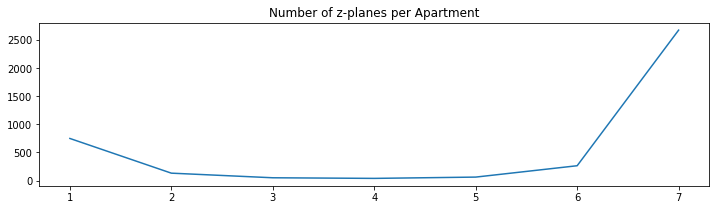

In [9]:
cell_data.groupby(['acq_cohort', 'st_num', 'apt_num'])['acq_z'].nunique()\
    .value_counts().sort_index()\
    .plot(title='Number of z-planes per Apartment', figsize=(12, 3))

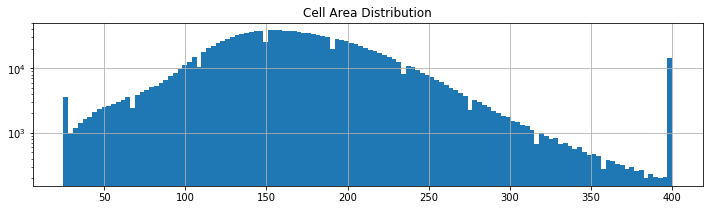

In [10]:
ax = cell_data['area'].clip(min_cell_size, max_cell_size).hist(bins=128, figsize=(12, 3))
ax.set_yscale('log')
ax.set_title('Cell Area Distribution')
None

In [11]:
if start_of_experiment is None:
    start_of_experiment = cell_data['acq_datetime'].min()
    print('Inferred experiment start time as "{}"'.format(start_of_experiment))
else:
    print('Using given experiment start time "{}"'.format(start_of_experiment))

Using given experiment start time "2018-05-31 16:10:00"


### Growth Rate Modeling

In [21]:
df = (
    # Remove cells outside of size filter
    cell_data[cell_data['area'].between(min_cell_size, max_cell_size)]
    
    # Group by what is effectively the original image id (acq_id) 
    # and location of apartment within image (apt_id) -- everything
    # else included is less unique than these things but is necessary for
    # downstream processing
    .groupby(['acq_id', 'apt_id', 'st_num', 'apt_num', 'acq_datetime', 'acq_cohort'])\
    
    # Count number of cells
    .size().rename('cell_count').reset_index()
)

# Compute time elapsed since start of experiment and replace absolute time of measurement
df['elapsed_hours'] = (df['acq_datetime'] - start_of_experiment) / np.timedelta64(1, 'h')
df = df.drop('acq_datetime', axis=1)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119605 entries, 0 to 119604
Data columns (total 7 columns):
acq_id           119605 non-null object
apt_id           119605 non-null int64
st_num           119605 non-null object
apt_num          119605 non-null object
acq_cohort       119605 non-null object
cell_count       119605 non-null int64
elapsed_hours    119605 non-null float64
dtypes: float64(1), int64(2), object(4)
memory usage: 6.4+ MB


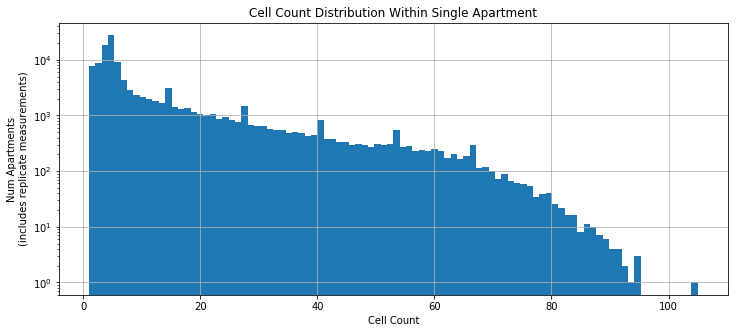

In [22]:
# Sanity check the number of cells inferred within each apartment image
ax = df['cell_count'].hist(bins=96, figsize=(12, 5))
ax.set_yscale('log')
ax.set_title('Cell Count Distribution Within Single Apartment')
ax.set_xlabel('Cell Count')
ax.set_ylabel('Num Apartments\n(includes replicate measurements)')
None

In [23]:
# Regroup by apartment + time and compute median cell count across all measurements
df = df.groupby(['acq_cohort', 'st_num', 'apt_num', 'elapsed_hours'])\
    .agg({'cell_count': 'median'}).reset_index()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26708 entries, 0 to 26707
Data columns (total 5 columns):
acq_cohort       26708 non-null object
st_num           26708 non-null object
apt_num          26708 non-null object
elapsed_hours    26708 non-null float64
cell_count       26708 non-null float64
dtypes: float64(2), object(3)
memory usage: 1.0+ MB


In [24]:
# Compute growth rates
dfg = df.groupby(['acq_cohort', 'st_num', 'apt_num'])\
    .apply(lambda g: modeling.get_growth_rate(g['elapsed_hours'] / 24, g['cell_count']))\
    .rename('growth_rate').reset_index()
dfg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3971 entries, 0 to 3970
Data columns (total 4 columns):
acq_cohort     3971 non-null object
st_num         3971 non-null object
apt_num        3971 non-null object
growth_rate    3182 non-null float64
dtypes: float64(1), object(3)
memory usage: 124.2+ KB


In [25]:
print('Num unique apartments:', dfg['apt_num'].nunique())

Num unique apartments: 243


In [26]:
print('Num unique apt+st combinations:', len(dfg[['apt_num', 'st_num']].drop_duplicates()))

Num unique apt+st combinations: 2391


### Results

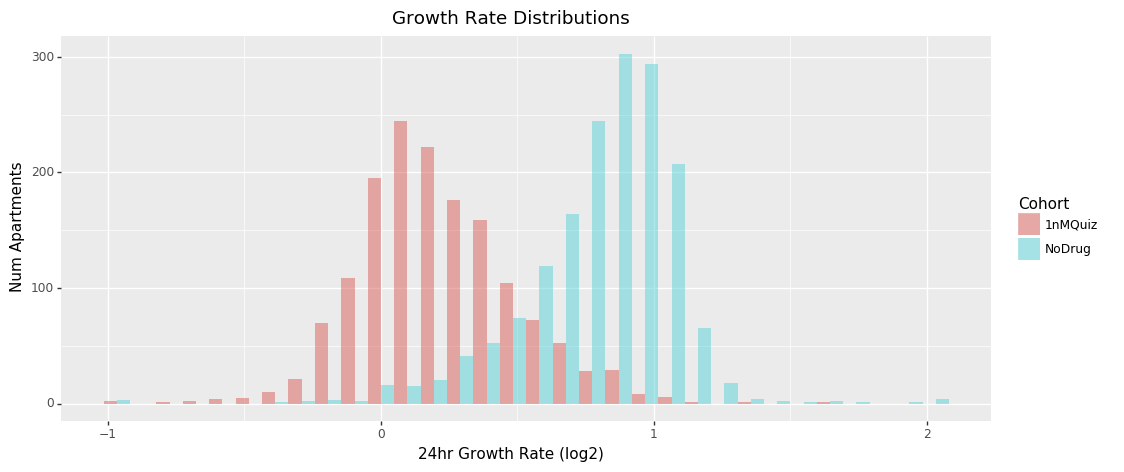

<ggplot: (8773603279133)>

In [27]:
dfp = dfg.copy()
dfp = dfp[dfp['growth_rate'].notnull()]
dfp['growth_rate'] = dfp['growth_rate'].clip(-1, 2)
p = (
    pn.ggplot(dfp, pn.aes(x='growth_rate', fill='acq_cohort')) +
    pn.geom_histogram(alpha=.5, position='dodge', bins=32) + 
    pn.scale_fill_discrete(guide=pn.guide_legend(title='Cohort')) +
    pn.theme(figure_size=(12, 5)) + 
    pn.xlab('24hr Growth Rate (log2)') +
    pn.ylab('Num Apartments') +
    pn.ggtitle('Growth Rate Distributions')
)
p

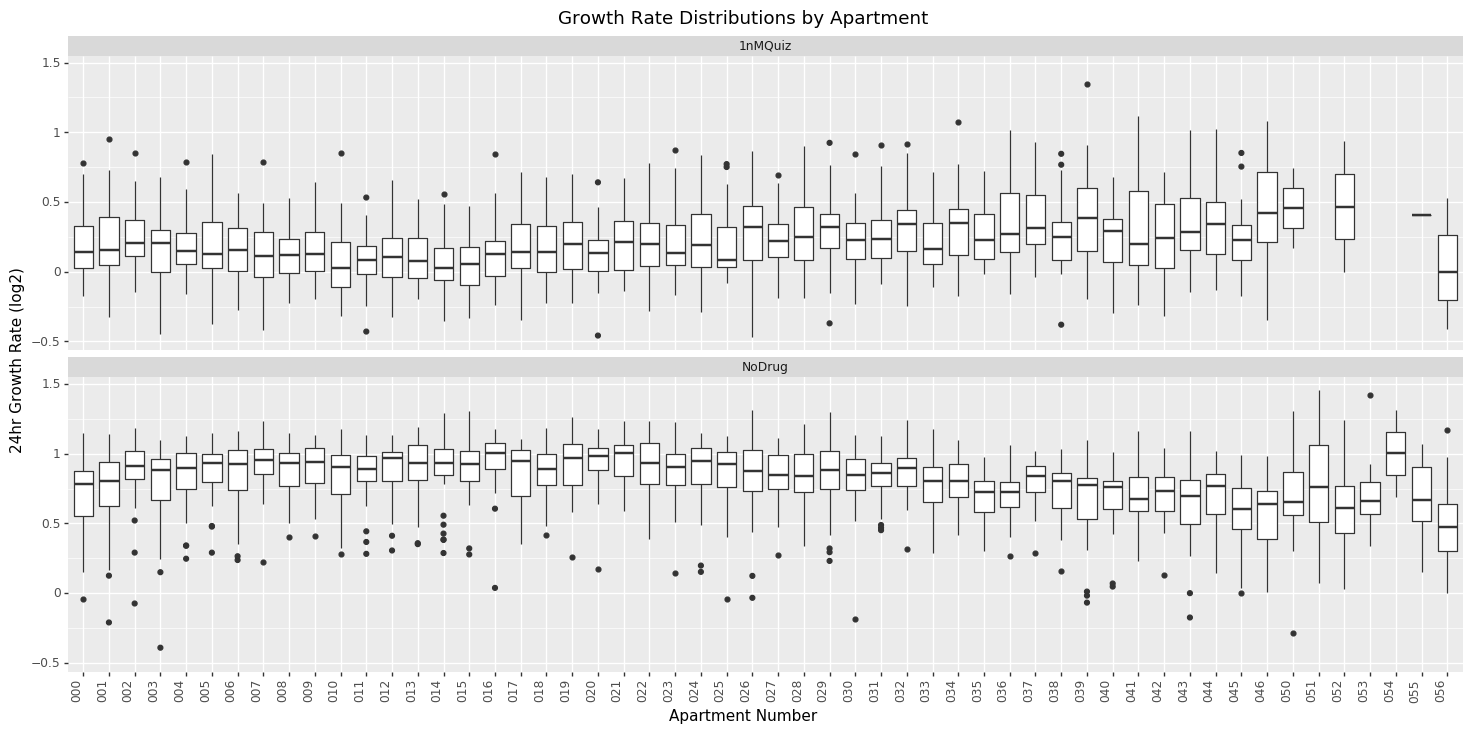

<ggplot: (8773599945522)>

In [28]:
dfp = dfg.copy()
dfp = dfp[dfp['growth_rate'].between(-.5, 1.5)]
dfp = dfp[dfp['apt_num'].astype(np.int) <= 56]
p = (
    pn.ggplot(dfp, pn.aes(x='apt_num', y='growth_rate')) +
    pn.geom_boxplot(position='dodge') +
    pn.facet_wrap('~acq_cohort', ncol=1) +
    pn.theme(figure_size=(18, 8), axis_text_x=pn.element_text(rotation=90, hjust=1)) + 
    pn.xlab('Apartment Number') +
    pn.ylab('24hr Growth Rate (log2)') +
    pn.ggtitle('Growth Rate Distributions by Apartment')
)
p

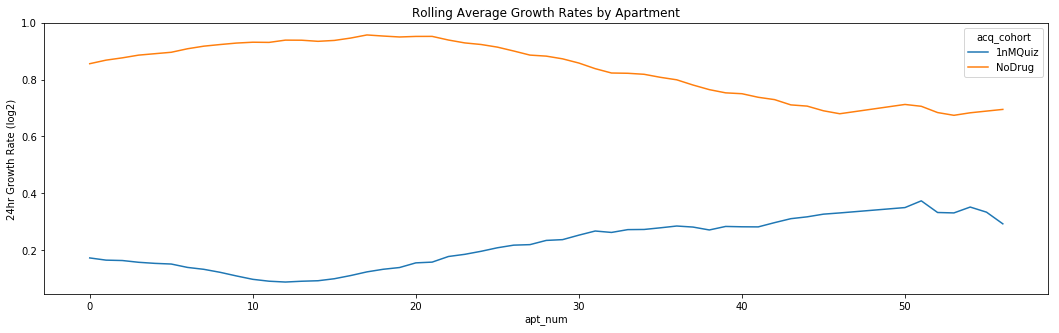

In [29]:
ax = (
    dfp.pipe(lambda d: d.assign(apt_num=d.apt_num.astype(int)))
    .groupby(['apt_num', 'acq_cohort'])['growth_rate'].median().unstack()
    .rolling(10, min_periods=1, center=True).mean()
).plot(figsize=(18, 5))
ax.set_ylabel('24hr Growth Rate (log2)')
ax.set_title('Rolling Average Growth Rates by Apartment')
None